<h1 style="text-align: center;"> Where to Frac? Analyze Well Log Data to find target rock formation </p>

## Table of contents

1. [The problem statement](#The-problem-statement)

2. [Step 1: Answering the question](#Step-1:-Answering-the-question)

3. [Step 2: Checking the data](#Step-2:-Checking-the-data)

4. [Step 3: Tidying the data](#Step-3:-Tidying-the-data)

5. [Step 4: Rock Type Analysis](#Step-4:-Rock-Type-Analysis)

6. [Conclusions and Future Work](#Conclusions-and-Future-Work)


## The problem statement

[[ go back to the top ]](#Table-of-contents)

We will analyze the well log data with the essential measurements acquired by a logging tool. The aim is to carry out Rock type analysis using these input measurements. The rock type determines the probability of finding the Hydrocarbon reservior(Oil and Gas) in those formations and help decide where in the cased hole to perform Fracturing(Frac) operation. The data however is not clean and needs to be looked at before jumping into any analysis. 

We will use K-Means Unsupervised MAchine Learning model to determine the clusters of rock formatiomns. From these clusters of Rock formations we will find the target rock with Hyrocarbon reservior to perform Frac operations on <br>

**Note:** The data set we're working with is synthetic and has been modified for demonstration purposes.

## Step 1: Answering the question

[[ go back to the top ]](#Table-of-contents)

The first step to any data analysis project is to define the question or problem we're looking to solve, and to define a measure (or set of measures) for our success at solving that task. The data analysis checklist makes us answer a handful of questions to accomplish that.

We're trying to classify the rock type based on the log measurements: <br >``'GammaRay(API)', 'ShaleVolume', 'Resistivity', 'Sonic Delta-T', 'Vp(m/s)', 'Vs', 'Density', 'NeutronPorosity', 'DensityPorosity(g/cc)', 'PoissonRatio'.``

We're building part of a data analysis pipeline to automate the process of rock type identification. In the future, this pipeline will be connected to another pipeline that automatically highlights what kind of rock we are drilling through. This can help take important decisions on the drilling parameters to use, mud pressure that needs to be maintained etc.

Notice that we've spent a fair amount of time working on the problem without writing a line of code or even looking at the data.

**Thinking about and documenting the problem we're working on is an important step to performing effective data analysis that often goes overlooked.** 

## Step 2: Checking the data

[[ go back to the top ]](#Table-of-contents)

The next step is to look at the data we're working with. Even curated data sets from the government can have errors in them, and it's vital that we spot these errors before investing too much time in our analysis.

Generally, we're looking to answer the following questions:

* Is there anything wrong with the data?
* Are there any quirks with the data?
* Do I need to fix or remove any of the data?

Let's start by reading the data into a pandas DataFrame.

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are:

* **NumPy**: Provides a fast numerical array structure and helper functions.
* **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
* **scikit-learn**: The essential Machine Learning package in Python.
* **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
* **Seaborn**: Advanced statistical plotting library.
* **pandas-profiling**: An open source Python module with which we can quickly do an exploratory data analysis with just a few lines of code.

In [309]:
# Load required packages
import numpy as np
import pandas as pd

# ML Libraries
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.impute import KNNImputer

# Plotting Libraries
%matplotlib nbagg
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

# Data Analysis libraries
#from pandas_profiling import ProfileReport
#pd.set_option('display.max_rows', 50)

In [320]:
# Load the dataset
import requests
import io

   
url = "https://raw.githubusercontent.com/jkhan-prog/Where-to-Frac/main/well_log.csv" # Make sure the url is the raw version of the file on GitHub
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe
well_log = pd.read_csv(io.StringIO(download.decode('utf-8')))
well_log.head(10)

,GammaRay(API),ShaleVolume,Resistivity,Sonic,Vp(m/s),Vs(m/s),Density,NeutronPorosity,DensityPorosity(g/cc),PoissonRatio,Depth(m)
0,73.215,0.7965,0.25,137.81,7256.3675,2799.0030,2.1278,-999.25,0.2818,0.4126,2007
1,69.152,0.7391,0.20,138.06,7243.2276,2804.5841,2.1202,-999.25,0.2893,0.4118,2008
2,65.965,0.6940,0.21,138.06,7243.2276,2817.0360,2.1149,-999.25,0.2946,0.4109,2009
3,68.215,0.7258,0.27,137.31,7282.7908,2839.0723,2.1217,-999.25,0.2889,0.4104,2010
4,70.840,0.7630,0.36,136.31,7336.2189,2870.3577,2.1301,-999.25,0.2819,0.4096,2011
5,62.262,0.6415,0.52,134.31,7445.4620,2989.7909,2.1242,-999.25,0.2911,0.4039,2012
6,61.637,0.6327,0.70,127.78,7825.9509,3290.0682,2.1513,-999.25,0.2744,0.3927,2013
7,62.043,0.6384,0.79,125.78,7950.3896,3385.7098,2.1609,-999.25,0.2681,0.3892,2014
8,58.855,0.5932,0.72,126.28,7918.9104,3374.7286,2.1533,-999.25,0.2750,0.3890,2015
9,62.355,0.6428,0.61,123.78,8078.8496,3484.8607,2.1706,-999.25,0.2618,0.3857,2016


In [276]:
well_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   GammaRay(API)          321 non-null    float64
 1   ShaleVolume            331 non-null    float64
 2   Resistivity            331 non-null    float64
 3   Sonic                  331 non-null    float64
 4   Vp(m/s)                331 non-null    float64
 5   Vs(m/s)                331 non-null    float64
 6   Density                331 non-null    float64
 7   NeutronPorosity        331 non-null    float64
 8   DensityPorosity(g/cc)  331 non-null    float64
 9   PoissonRatio           331 non-null    float64
 10  Depth(m)               331 non-null    int64  
dtypes: float64(10), int64(1)
memory usage: 28.6 KB


###  Observations

Data Statistics: 
1. There are 11 variables/measurements and 331 observations/depth values 
2. There are 10 cells which contain missing values 


Variable Types: 

1. There are 10 Numerical and 1 Categorical variable

In [277]:
well_log.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
GammaRay(API),321.0,59.234143,8.876298,28.2860,53.91800,59.7620,65.59000,80.6520
ShaleVolume,331.0,0.597459,0.130688,0.1124,0.52125,0.6065,0.69055,0.9167
Resistivity,331.0,0.498157,0.182426,0.1500,0.35500,0.5000,0.65000,1.0200
Sonic,331.0,128.234894,6.045973,110.5300,124.15500,128.3100,132.68500,143.5600
Vp(m/s),331.0,7815.715889,373.572530,6965.7286,7536.65365,7793.6248,8054.45625,9047.3175
Vs(m/s),331.0,3292.871025,297.005615,2609.2279,3077.41765,3290.0682,3476.89620,4426.3291
Density,331.0,2.113194,0.263802,0.0000,2.12415,2.1449,2.16585,2.2313
NeutronPorosity,331.0,-999.250000,0.000000,-999.2500,-999.25000,-999.2500,-999.25000,-999.2500
DensityPorosity(g/cc),331.0,0.279328,0.022343,0.2188,0.26480,0.2792,0.29220,0.3471
PoissonRatio,331.0,0.392156,0.011285,0.3427,0.38500,0.3920,0.39915,0.4193


In [278]:
well_log.isna().sum()

GammaRay(API)            10
ShaleVolume               0
Resistivity               0
Sonic                     0
Vp(m/s)                   0
Vs(m/s)                   0
Density                   0
NeutronPorosity           0
DensityPorosity(g/cc)     0
PoissonRatio              0
Depth(m)                  0
dtype: int64

In [279]:
colmns = well_log.columns
for col in colmns:
    print('\n Unique Values of {} are \n'.format(col), well_log[col].unique())
    print('Unique Numbers of {} ='.format(col), well_log[col].nunique())
    print('*' * 90)


 Unique Values of GammaRay(API) are 
 [73.215 69.152 65.965 68.215 70.84  62.262 61.637 62.043 58.855 62.355
 53.918 53.793 56.543 57.73  57.199 52.105 51.137 59.762 54.168 49.199
 45.543 47.48  56.512 59.824 58.105 53.418 56.48  58.543 58.199 47.105
 57.043 63.512 68.152 61.762 62.293 70.402 69.527 58.637 56.137 57.293
 62.105 59.105 64.59  66.402 68.902 66.152 56.637 62.98  66.09  67.527
 67.59  61.98  59.98  61.137 55.793 56.324 53.23  63.699 73.652 65.715
 60.418 62.855 55.293 55.199 59.387 57.355 46.793 49.98  43.293 36.262
 31.599 35.887 44.574 63.355 64.09  48.355 48.793 51.387 49.449 45.699
 50.324 54.355 59.699 64.84  64.652 62.668 63.605 58.355 56.293 61.23
 57.262 67.652 66.84  63.574 73.715 75.777 73.402 74.465 66.277 64.527
 63.074 59.512 50.637 50.98  44.043 46.855 60.574 63.949 54.73  52.824
 47.543 51.605 56.043 60.512 71.027 64.777 57.949 53.855 50.418 45.355
 45.324 56.949 63.043 65.09  67.402 61.699 67.777 61.324 56.824 65.527
 68.777 64.402 61.824 57.574 55.949 58.

In [280]:
#Density has entries with value=0. Lets see all instances of it. 
well_log[well_log['Density'] == 0]

,GammaRay(API),ShaleVolume,Resistivity,Sonic,Vp(m/s),Vs(m/s),Density,NeutronPorosity,DensityPorosity(g/cc),PoissonRatio,Depth(m)
321,45.543,0.4036,0.37,132.31,7558.0077,3147.3555,0.0,-999.25,0.3137,0.3951,2328
322,47.480,0.4310,0.44,127.28,7856.6939,3375.0354,0.0,-999.25,0.2971,0.3869,2329
323,56.512,0.5594,0.55,119.03,8401.2434,3763.5865,0.0,-999.25,0.2579,0.3745,2330
324,59.824,0.6065,0.68,116.03,8618.4607,3918.7153,0.0,-999.25,0.2428,0.3697,2331
325,58.105,0.5820,0.65,118.03,8472.4223,3812.1862,0.0,-999.25,0.2521,0.3731,2332


### Observations 
- NeutronPorosity is a constant value, as the sensor either wasn't present or not working. We will drop this column.
- Depth in incrementing every reading, as expected while drilling.
- Gamma Ray has 10 missing entries.This could be due to sample of the gamma sensor not read at those times. 
- Density has 5 Zero entries, in sequence,  which is suspicious as the density cannot be zero.

#### Reason for choosing variables for clustering

- NeutronPorosity is a constant value. So, we will drop it.
- All other features are significant for clustering.

In [281]:
well_log.drop('NeutronPorosity', axis=1, inplace=True)

In [282]:
all_cols = [
    'GammaRay(API)', 'ShaleVolume', 'Resistivity', 'Sonic', 'Vp(m/s)',
    'Vs(m/s)', 'Density', 'DensityPorosity(g/cc)', 'PoissonRatio', 'Depth(m)'
]

In [283]:
well_log[all_cols].head()

,GammaRay(API),ShaleVolume,Resistivity,Sonic,Vp(m/s),Vs(m/s),Density,DensityPorosity(g/cc),PoissonRatio,Depth(m)
0,73.215,0.7965,0.25,137.81,7256.3675,2799.0030,2.1278,0.2818,0.4126,2007
1,69.152,0.7391,0.20,138.06,7243.2276,2804.5841,2.1202,0.2893,0.4118,2008
2,65.965,0.6940,0.21,138.06,7243.2276,2817.0360,2.1149,0.2946,0.4109,2009
3,68.215,0.7258,0.27,137.31,7282.7908,2839.0723,2.1217,0.2889,0.4104,2010
4,70.840,0.7630,0.36,136.31,7336.2189,2870.3577,2.1301,0.2819,0.4096,2011


Next, Lets look at the univariate and  analysis with Exploratory Data Analysis(EDA). 
Univariate analysis is done to see a variable's distribution and Bivariate is done to check correlation between two variables

# EDA

### Univariate analysis

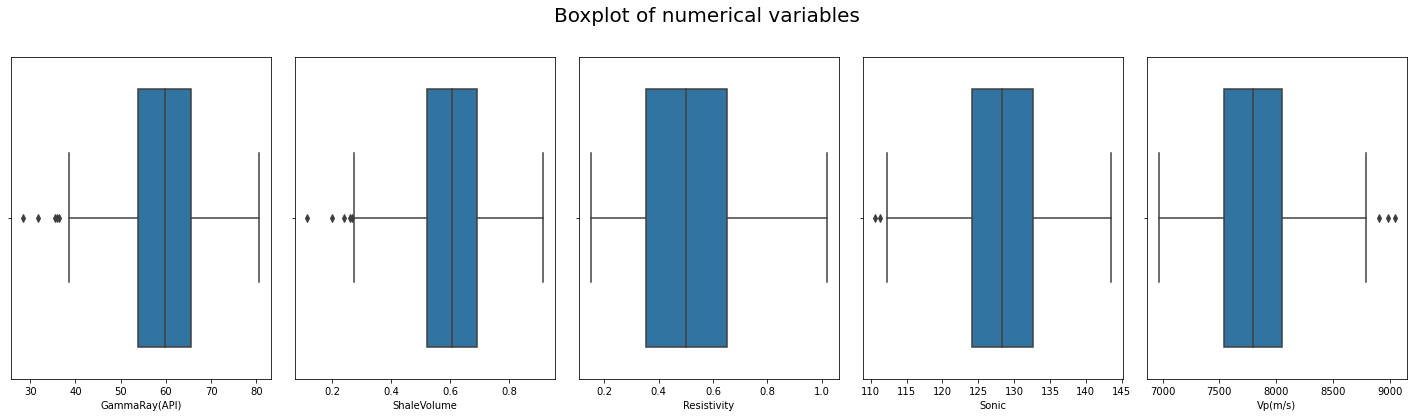

In [284]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6))
fig.suptitle('Boxplot of numerical variables', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], x=well_log[cluster_cols[counter]])
    counter = counter + 1

fig.tight_layout(pad=2.0)

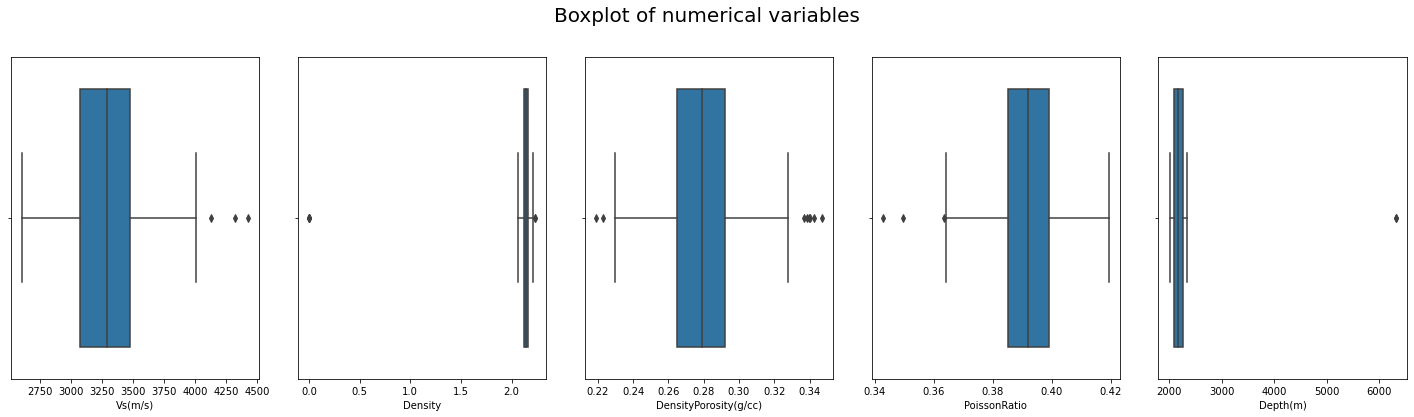

In [285]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6))
fig.suptitle('Boxplot of numerical variables', fontsize=20)
counter = 5
j = 0
for ii in range(5):
    sns.boxplot(ax=axes[j], x=well_log[cluster_cols[counter]])
    counter = counter + 1
    j = j + 1

fig.tight_layout(pad=2.0)

#### Observations
1. GammaRay value of 30 is a reading at surface. Looks to be Valid outlier.
2. Density=0 looks incorrect. We will cap them with the lowest non-zero Density value.
3. Depth = 6000' looks invalid,as the maximum depth from the log appears to be ~ 2300'

## Bivariate Analysis

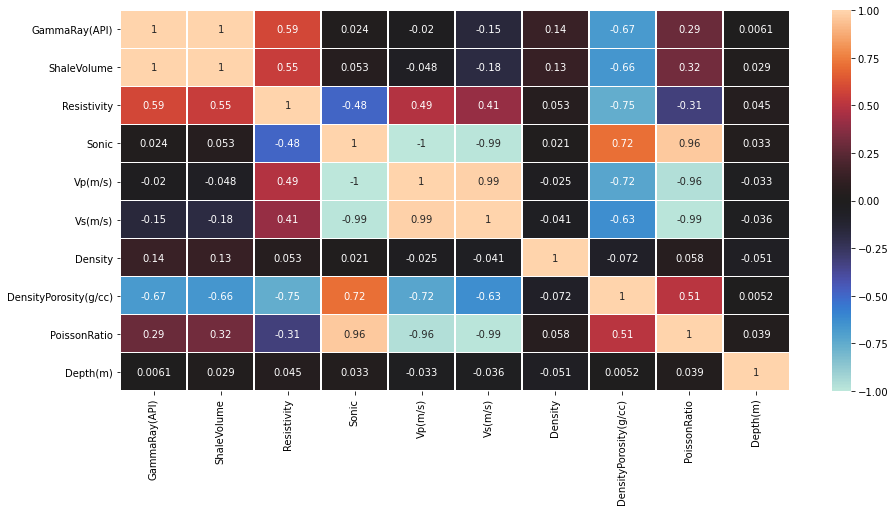

In [286]:
plt.figure(figsize=(15, 7))

sns.heatmap(
    well_log[cluster_cols].corr(),
    annot=True,
    linewidths=0.5,
    vmin=-1,
    vmax=1,
    center=0,
    cbar=True,
)

plt.show()

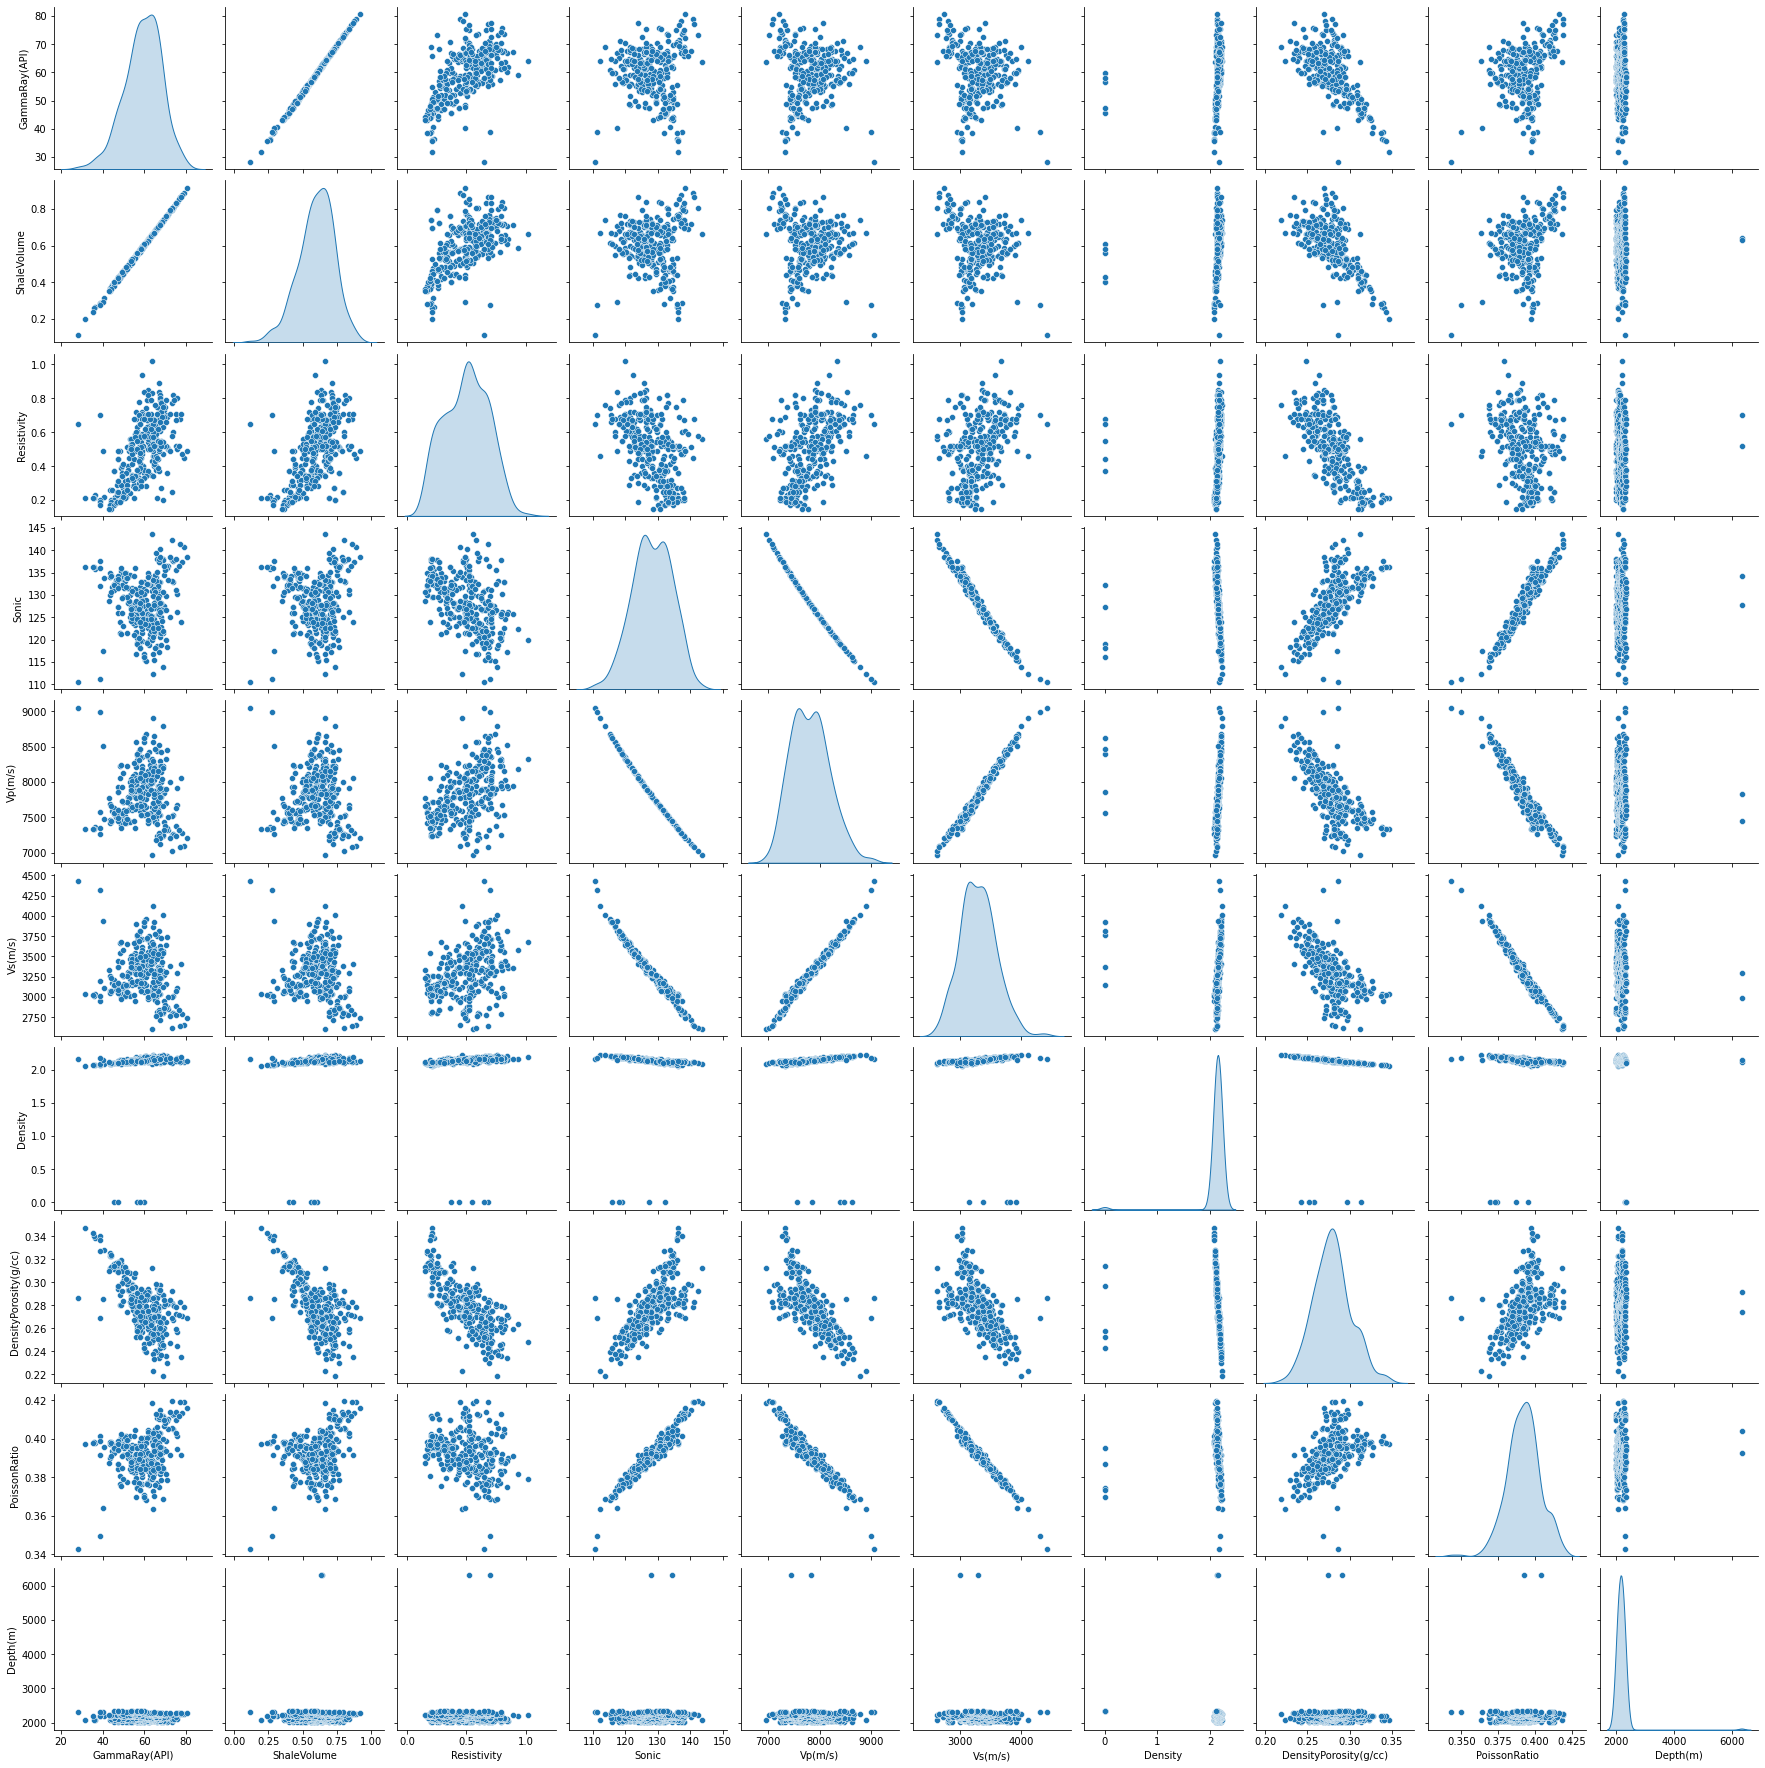

In [287]:
sns.pairplot(well_log[cluster_cols], diag_kind="kde")

### Observations
1. Gamma ray readings and shale volume are strongly correlated, wich is expected,  as shale formation has higher gamma ray counts.
2. Sonic and Vp and Vs are negatively correlated, which is expected, based on Lindseth's relationship

There are multiple correlation coefficients that you can check. For instance the widely known pearson correlation coefficient provides the linear correlation coefficient but in case you believe the variables are not linearly associated you may check spearman correlation coefficient which captures non linear monotonic correlations quite well.
For now we are only looking at the pearson correlation coefficient.

## Step 3: Tidying the data

[[ go back to the top ]](#Table-of-contents)

### Feature Engineering 

### Impute Missing Values 

Missing values in the column **Gamma Ray** column:

In [288]:
well_log[well_log['GammaRay(API)'].isnull()]

,GammaRay(API),ShaleVolume,Resistivity,Sonic,Vp(m/s),Vs(m/s),Density,DensityPorosity(g/cc),PoissonRatio,Depth(m)
301,NaN,0.7965,0.25,137.81,7256.3675,2799.0030,2.1278,0.2818,0.4126,2308
302,NaN,0.7391,0.20,138.06,7243.2276,2804.5841,2.1202,0.2893,0.4118,2309
303,NaN,0.6940,0.21,138.06,7243.2276,2817.0360,2.1149,0.2946,0.4109,2310
304,NaN,0.7258,0.27,137.31,7282.7908,2839.0723,2.1217,0.2889,0.4104,2311
305,NaN,0.7630,0.36,136.31,7336.2189,2870.3577,2.1301,0.2819,0.4096,2312
306,NaN,0.6415,0.52,134.31,7445.4620,2989.7909,2.1242,0.2911,0.4039,6313
307,NaN,0.6327,0.70,127.78,7825.9509,3290.0682,2.1513,0.2744,0.3927,6314
308,NaN,0.6384,0.79,125.78,7950.3896,3385.7098,2.1609,0.2681,0.3892,2315
309,NaN,0.5932,0.72,126.28,7918.9104,3374.7286,2.1533,0.2750,0.3890,2316
310,NaN,0.6428,0.61,123.78,8078.8496,3484.8607,2.1706,0.2618,0.3857,2317


It's not ideal that we had to drop those rows, especially considering they're all sequential as far as the depth of the well is concerned. Since it seems like the missing data is systematic — all of the missing values are in the same column this error could potentially bias our analysis.

Most frequently used approaches to handle the missing data are: <br>
1. Do nothing
2. Drop entire row 
3. Fill with the mean or median  value of the measurement for entire well section
4. Fill with the previous or the next value to missing entry 
4. Interpolate between the neighbouring values(value just before and after the missing entry) 
5. Impute using k-NN 

Depending on the use case you can decide which approach works the best. In this case we will use the k-NN approach to fill the values. In the k-NN approach the other available meaurements (Shale Volume, Resistivity, Sonic) will be used to determine the likely values of Gamma Ray in the missing interval. <br>
Ref: [Nearest Neighbors Imputation](https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation)

In [289]:
# k-NN to determine the missing Gamma Ray values

nan = np.nan
X = np.array(
    well_log.loc[:, ['GammaRay(API)', 'ShaleVolume', 'Resistivity', 'Sonic']])
imputer = KNNImputer(n_neighbors=2, weights="uniform")
well_log['GammaRay_Imputed'] = imputer.fit_transform(X)[:, 0]

In [290]:
# Compare the missing Gamma Ray values

well_log.loc[297:312, ['GammaRay(API)', 'GammaRay_Imputed']]

,GammaRay(API),GammaRay_Imputed
297,61.012,61.0120
298,40.105,40.1050
299,28.286,28.2860
300,38.855,38.8550
301,NaN,70.9960
302,NaN,67.5585
303,NaN,67.5585
304,NaN,67.5275
305,NaN,71.0900
306,NaN,61.9960



### Handling Outliers or Incorrect values 

**Density** column has some zero entries and the **Depth** also seems to have some outlier values.

#### 1. Density 

We will replace Density= 0 with lowest non-zero Density value 

In [291]:
well_log.Density.replace(0, method='ffill', inplace=True)

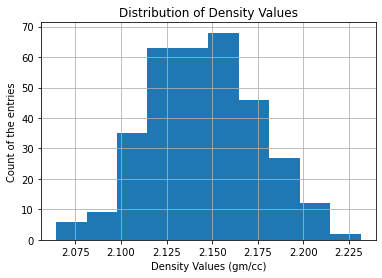

In [292]:
# Plot the Histogram to confirm zero density values
well_log.Density.hist()
plt.title('Distribution of Density Values')
plt.xlabel('Density Values (gm/cc)')
plt.ylabel('Count of the entries')
plt.show()

Density Values look reasonable now.

#### 2. Depth 

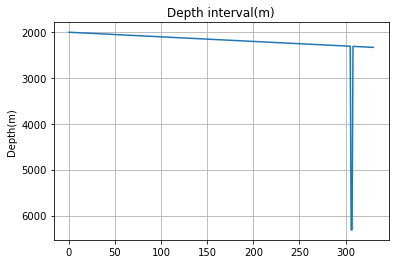

In [293]:
# Plot the Histogram to confirm outliers in depth values

well_log['Depth(m)'].plot()
plt.title('Depth interval(m)')
plt.ylabel('Depth(m)')
plt.gca().invert_yaxis()
plt.grid()
plt.show()

The depth value in the well section shows a sudden jump to 6000m+ (outlier) which does not seem to be right. It could be an error in recording data. We need to smoothen it out and remove these outlier values.

In [294]:
# 1. Identify the outlier values
# 2. Assign NaN values to these outliers
# 3. Interpolate(linear) based on the surrounding depth values

well_log.loc[well_log['Depth(m)'] > 6000, 'Depth(m)'] = np.nan
transformed_depth = well_log['Depth(m)'].interpolate(method='linear')
well_log['Depth(m)_imputed'] = transformed_depth

In [295]:
well_log.loc[300:310, ['Depth(m)', 'Depth(m)_imputed']]

,Depth(m),Depth(m)_imputed
300,2307.0,2307.0
301,2308.0,2308.0
302,2309.0,2309.0
303,2310.0,2310.0
304,2311.0,2311.0
305,2312.0,2312.0
306,NaN,2313.0
307,NaN,2314.0
308,2315.0,2315.0
309,2316.0,2316.0


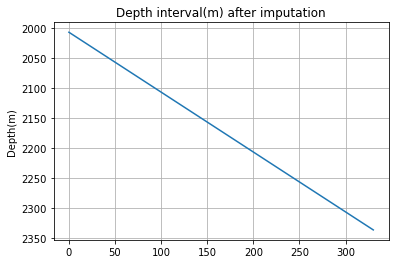

In [296]:
# Imputed Depth values

well_log['Depth(m)_imputed'].plot()
plt.title('Depth interval(m) after imputation')
plt.ylabel('Depth(m)')
plt.gca().invert_yaxis()
plt.grid()
plt.show()

Now the depth seems to be okay. The well section is between 2300 and 2350 m depth interval.

## Remove redundant columns 

Since the Neutron Porosity is constant value -999.25 through out, it seems to be redundant and can be removed from the analysis. Also going forward we can use the imputed Gamma Ray and Depth values hence we do not need th original columns. 


In [297]:
well_log.drop(columns=['GammaRay(API)', 'Depth(m)'], inplace=True)

Now that the data is in a clean form, we can proceed with the Rock Typing.

## Step 4: Rock Type Analysis

[[ go back to the top ]](#Table-of-contents)

In [298]:
well_log.head()

,ShaleVolume,Resistivity,Sonic,Vp(m/s),Vs(m/s),Density,DensityPorosity(g/cc),PoissonRatio,GammaRay_Imputed,Depth(m)_imputed
0,0.7965,0.25,137.81,7256.3675,2799.0030,2.1278,0.2818,0.4126,73.215,2007.0
1,0.7391,0.20,138.06,7243.2276,2804.5841,2.1202,0.2893,0.4118,69.152,2008.0
2,0.6940,0.21,138.06,7243.2276,2817.0360,2.1149,0.2946,0.4109,65.965,2009.0
3,0.7258,0.27,137.31,7282.7908,2839.0723,2.1217,0.2889,0.4104,68.215,2010.0
4,0.7630,0.36,136.31,7336.2189,2870.3577,2.1301,0.2819,0.4096,70.840,2011.0


For rock typing we can use any unsupervised clustering technique. **k-means** is the most widely used clustering technique which samples the dataset into k groups/clusters of equal variance by minimizing the criteria called **Inertia** or **within-cluster-sum-of-squares**.  <br>
Refer: [sklearn-k-means-Clustering](https://scikit-learn.org/stable/modules/clustering.html#k-means) <br>

Prior to implementation of k-means, the data needs to be normalized as otherwise the clusters tend to separate along the variables with higher variance. <br>
Refer: [feature_scaling_k-means](https://stats.stackexchange.com/questions/21222/are-mean-normalization-and-feature-scaling-needed-for-k-means-clustering)


In [299]:
# Preprocessing the dataset

logs_tmp = well_log.values
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(logs_tmp)
well_logs_scaled = pd.DataFrame(x_scaled)

C:\Users\nsiddiqui\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


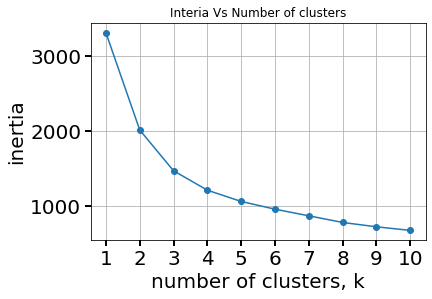

In [300]:
inertias = []
clusters_list = range(1,11)

# Compute Inertia value for different number of cluster
for num_clusters in clusters_list:
    # Create a KMeans instance with k clusters: model
    model=KMeans(n_clusters=num_clusters , random_state=123)
    
    # Fit model to samples
    model.fit(well_logs_scaled)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

# Plot the Inertia Vs Number of Clusters 
plt.plot(clusters_list, inertias, marker = 'o')

plt.xlabel('number of clusters, k', size=20)
plt.ylabel('inertia', size=20)
plt.xticks(clusters_list)
plt.title('Interia Vs Number of clusters')
plt.tick_params(direction='out', length=6, width=2, colors='k')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid( zorder=1)
plt.show()

The **Elbow method** is used to choose the appropriate number of clusters. The target is to define the number of clusters such that the total intra cluster variation [or **Inertia:** total within-cluster sum of square (WSS)]  is minimized that shows that the points within a cluster are similar to each other.

The Elbow method looks at the total WSS as a function of the number of clusters: One should choose a number of clusters so that adding another cluster doesn’t improve much better the total WSS. In our case the maximum drop in the Inertia happens up to 3 clusters. After 3 the inertia drop is not very significant. We have sufficient evidence to go with k = 3.

Let us now implement the k-means with 3 clusters and predict the 3 Rock types for the well section. 



In [301]:
# k-means implementation with 3 clusters

kmeans = KMeans(n_clusters=3)
kmeans.fit(well_logs_scaled)

labels_rocks = kmeans.predict(well_logs_scaled)
rocktypes = pd.DataFrame({'RockType':labels_rocks})
well_log['rock_types'] = rocktypes.RockType

In [302]:
well_logs_scaled_embedded = TSNE(n_components=2, learning_rate=200,random_state=10, 
                                 perplexity=50).fit_transform(well_logs_scaled)

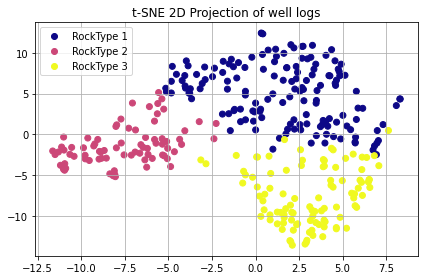

In [303]:
# Projecting the well log features into 2d projection using t-SNE

classes = ['RockType 1','RockType 2','RockType 3']
scatter = plt.scatter(well_logs_scaled_embedded[:,0],
            well_logs_scaled_embedded[:,1], 
            c =  rocktypes['RockType'], cmap = 'plasma' )
plt.title('t-SNE 2D Projection of well logs')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.grid()
plt.tight_layout()
#plt.show()

The 3 rock types identified can be seen pretty well on the 2D projection

### Plot well logs

In [304]:
# Display the well logs 

def well_log_display(top_depth,bottom_depth, df, list_columns):
    
    logs=df[(df['Depth(m)_imputed'] >= top_depth) & (df['Depth(m)_imputed'] <= bottom_depth)]
    fig, ax = plt.subplots(nrows=1, ncols=len(list_columns), figsize=(15,20),  sharey=True)
    fig.subplots_adjust(top=0.75,wspace=0.1)

    for axes in ax:
        axes.set_ylim (top_depth,bottom_depth)
        axes.yaxis.grid(True)
        axes.get_xaxis().set_visible(False) 
        
    for i in range(len(list_columns)):
        if (list_columns[i] == 'rock_types'):
            ax1=ax[i].twiny()
            label = logs.rock_types
            tagged_depths = logs['Depth(m)_imputed']
            rock_type_depth(ax1,tagged_depths, label)
            ax1.set_xlabel(list_columns[i],color= list(colors.keys())[i], fontsize=15)    
            ax1.minorticks_off()
            ax1.grid(False)
            
        elif (list_columns[i] == 'Resistivity'):
            ax1=ax[i].twiny()
            ax1.set_xlim(0.1,10)
            ax1.set_xscale('log')
            ax1.grid(True)
            ax1.plot(logs[list_columns[i]], logs['Depth(m)_imputed'], label=list_columns[i], color=list(colors.keys())[i]) 
            ax1.spines['top'].set_position(('outward',40))
            ax1.set_xlabel(list_columns[i],color= list(colors.keys())[i], fontsize=10)    
            ax1.tick_params(axis='x', colors=list(colors.keys())[i],labelsize = 10)
        
        else:
            ax1=ax[i].twiny()
            ax1.grid(True)
            ax1.plot(logs[list_columns[i]], logs['Depth(m)_imputed'], label=list_columns[i], color=list(colors.keys())[i]) 
            ax1.spines['top'].set_position(('outward',40))
            ax1.set_xlabel(list_columns[i],color= list(colors.keys())[i], fontsize=10)    
            ax1.tick_params(axis='x', colors=list(colors.keys())[i],labelsize = 10)

In [305]:
# Display the rock type track 

def rock_type_depth (ax, depth, label):
    patches = []
    for i in range(len(well_log)):
        poly=Rectangle((0,depth[i]), 4, 1)
        patches.append(poly)

    p = PatchCollection(patches, match_original=False,alpha=0.6)

    colors = 1000*np.array(well_log.rock_types)
    p.set_array(np.array(colors))
    ax.add_collection(p)
    ax.invert_yaxis()
    x_pos_label=['', '','','']
    ax.set_xticklabels(x_pos_label, rotation = 0)
    ax.get_xaxis().set_visible(True)

<ipython-input-305-5962acd10083>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_pos_label, rotation = 0)


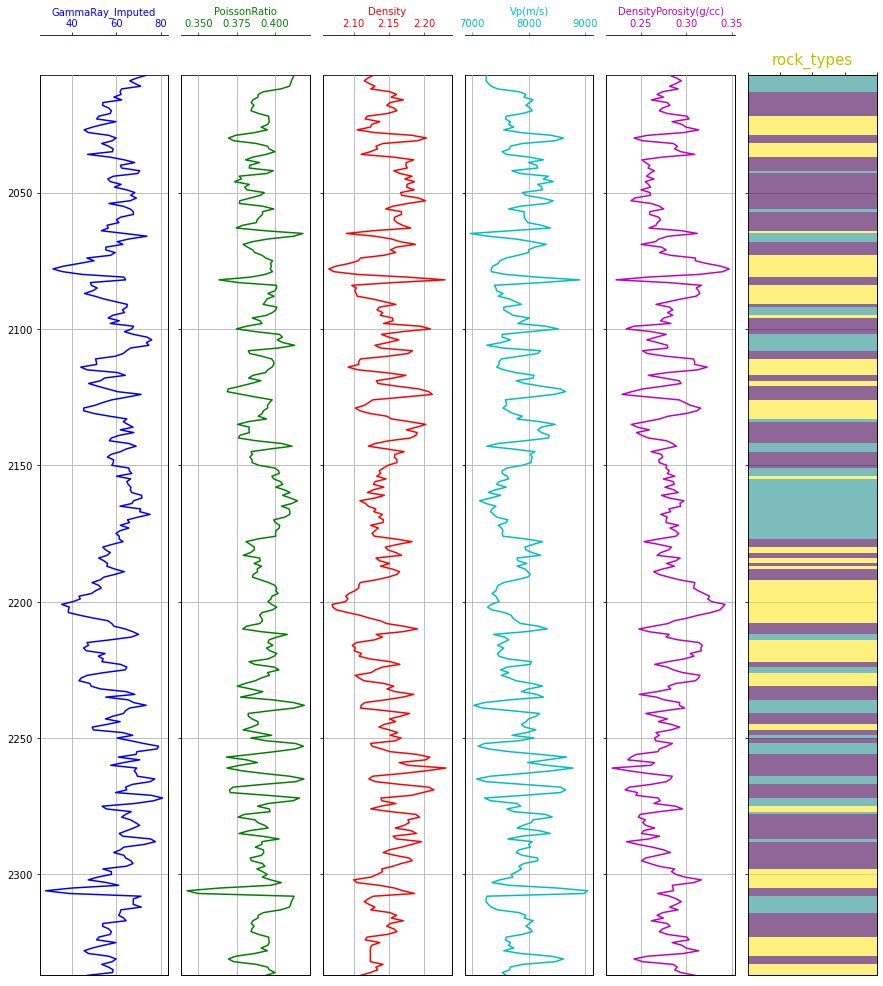

In [308]:
# Display the combined plot for 'ShaleVolume', 'Resistivity', 'GammaRay_Imputed','Density' agaimst the cluster of 'rock_types'

list_columns = ['GammaRay_Imputed','PoissonRatio','Density','Vp(m/s)','DensityPorosity(g/cc)','rock_types']
well_log_display(well_log['Depth(m)_imputed'].min(),well_log['Depth(m)_imputed'].max(), well_log, list_columns)

## Conclusions and Future Work

[[ go back to the top ]](#Table-of-contents)


Each colour corresponds to a particular rock type/lithology identified by the unsupervised machine learning algorithm. You can further intepret the kind of rocks corresponding to each of the clusters.

The log responses with respect to bed boundaries are different for different lithologies. The three rocktypes are:
- Sands have characteristics of low GR, low Poisson’s ratio, low density, low velocity values and high porosity values 
- Shales, on the other hand have high GR values compared to sand. Compared to Sands, for Shales porosity is extremely low, while density, Poisson’s ratio and velocity values are higher. 
- Silt has properties in between sand and shales.


We have completed the Machine learning pipeline to demo rock type analysis starting from Exploratory Data Analysis to Rock type identification using unsupervised machine learning.

The dataset we have is a 330m well section and would contain rock types specific to the interval under consideration. Once these rock types are identified based on the input measurements, same model can be applied on another section to identify any overlap or similar rock types.

#### Future Work
The well log data is acquired by the logging tool during or after drilling the well. Different tools provide different measurements which behave differently depending on the nature of the rock being drilled. Analysis of the well logs together gives us the information about what kind of a rock we would be drilling. Machine Learning approach can automate the process of identification of rock. 
 
